In [48]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
        
class RestorePatternDataset(torch.utils.data.IterableDataset):
    def __init__(self):
        self.size = (32,32)
        self.min_size = (6,6)
        self.max_size = (30,30)
        self.min_pattern_size = (1,1)
        self.max_pattern_size = (4,4)
        self.occlusion = ["solid", "random"]
        self.strength = 0.75
        
    def __iter__(self):
        return self

    def __next__(self):
        h = torch.randint(self.min_size[0], self.max_size[0]+1, (1,)).item()
        w = torch.randint(self.min_size[1], self.max_size[1]+1, (1,)).item()
        ph = torch.randint(self.min_pattern_size[0], self.max_pattern_size[0]+1, (1,)).item()
        pw = torch.randint(self.min_pattern_size[1], self.max_pattern_size[1]+1, (1,)).item()
        pattern = torch.randint(10, (ph,pw))+1
        challenge = pattern.repeat((h+ph-1)//ph, (w+pw-1)//pw)[:h,:w]
        target = challenge.clone()
        
        ph = torch.randint(2, h-2, (1,)).item()
        pw = torch.randint(2, w-2, (1,)).item()
        dy = torch.randint(h-ph,(1,))
        dx = torch.randint(w-pw,(1,))
        pattern = (torch.rand(ph,pw) < self.strength)

        occlusion = self.occlusion[torch.randint(len(self.occlusion), (1,)).item()]
        if occlusion == "solid":
            color = torch.randint(10, (1,)).item() + 1
            challenge[dy:dy+ph, dx:dx+pw][pattern] = color
        elif occlusion == "random":
            color = torch.randint(10, (ph,pw)) + 1
            challenge[dy:dy+ph, dx:dx+pw][pattern] = color[pattern]
        else:
            assert False, "invalid occlusion"

        py,px = (self.size[0]-h),(self.size[1]-w)
        challenge = F.pad(challenge,(px//2, px-px//2, py//2, py-py//2))
        target = F.pad(target,(px//2, px-px//2, py//2, py-py//2))
        
        return challenge[None], target[None]

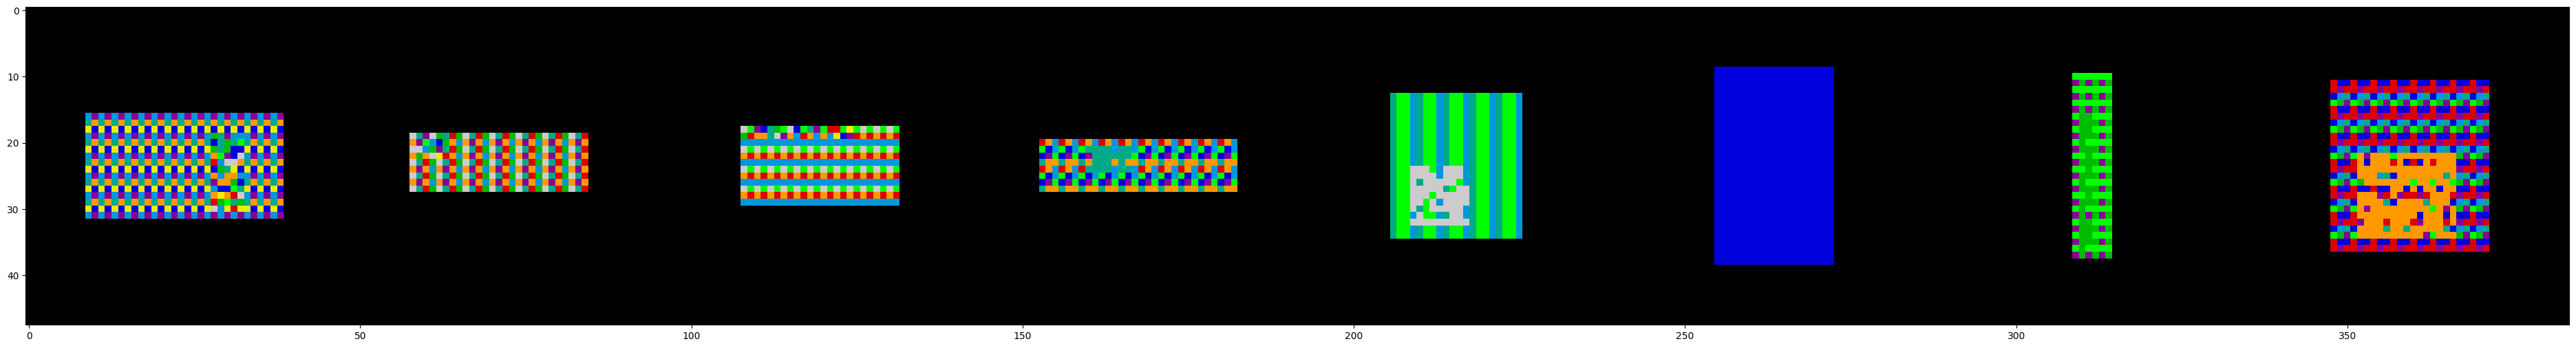

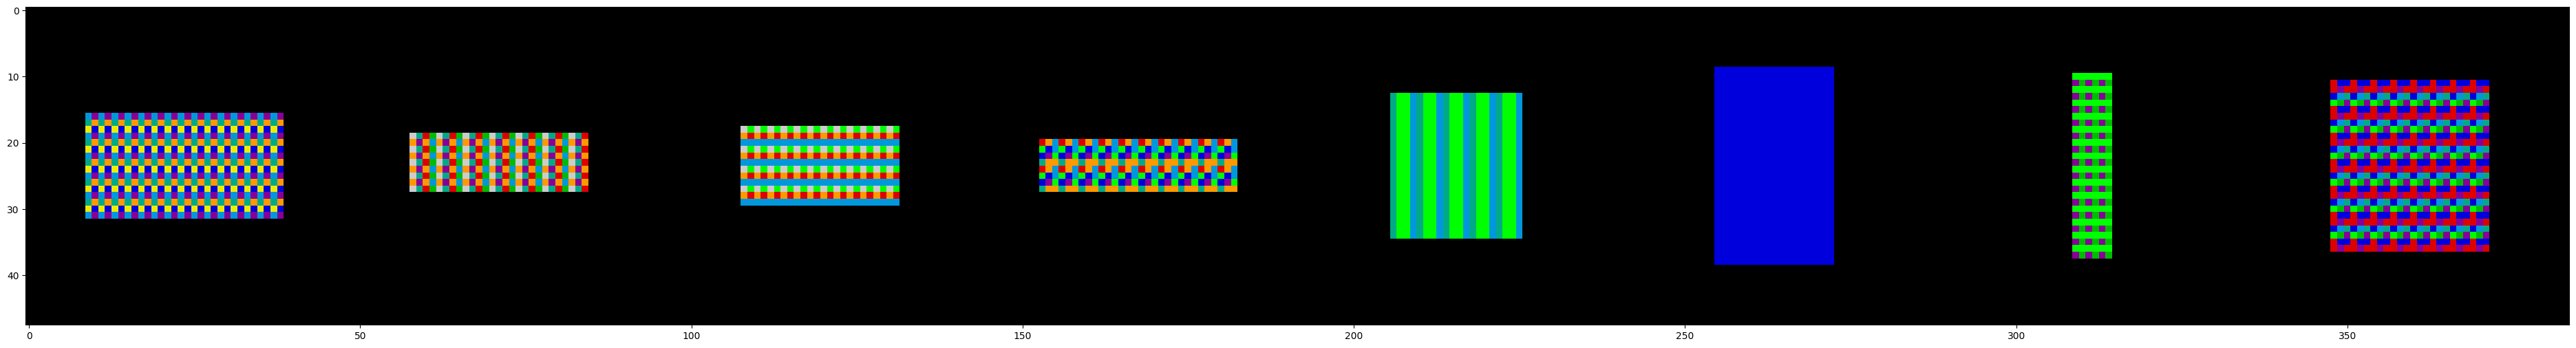

In [49]:
dataset = RestorePatternDataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=8)
batch, target = next(iter(loader))

batch = torch.cat([F.pad(b, (8,8,8,8)) for b in batch.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(batch.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()

target = torch.cat([F.pad(t, (8,8,8,8)) for t in target.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(target.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()
